# [LMSYS] Tf-Idf Attempts for Beginner (Eng/日本語)

The Purpose of this competition is to predict which is preferable between 2 responses (a, b) generated by different 2 Chatbots against various questions (3 options; "a", "b", Tie).  
As for me, I'd feel "I don't like a curt and safe response". This might mean a sentence that consists of commonplace and easy words only.      
Based on this assumption, I'd like to try some attempts using Tf-Idf, which is convenient to analyze the rareness of words.  

今回のお題は、様々な問いに対して２つのチャットボットが出す回答（a、b）について、どちらの回答のほうがユーザーにとって好ましいかを予測するというものです（「a」「b」「引き分け」の3択）。  
自分としては「木で鼻をくくったような無難な回答はイヤだな」という気がするのですが、これはすなわち、ありふれた単語だけで構成されている文章とも言えるのではないかと思いました。ということで、今回のお題については単語のレア度を判定するのに便利なTf-Idfを使って、スコアを上げていく試みをしていきたいと思います。  
  
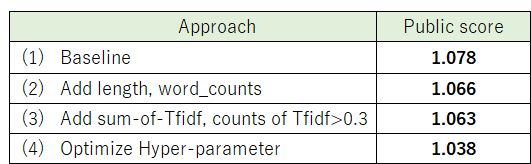

For some methods such as extraction of targets from 3 columns, credit to below notebook.  
3列にまたがるtargetの整理方法等については以下のNotebookを参考にさせていただきました。  
[https://www.kaggle.com/code/takapis/lmsys-lightgbm](http://)

# 1. Baseline


In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgbm
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
stopWords = stopwords.words("english")
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import LabelEncoder

pd.set_option("display.max_columns", None)
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_df = pd.read_csv("/kaggle/input/lmsys-chatbot-arena/train.csv")
test_df = pd.read_csv("/kaggle/input/lmsys-chatbot-arena/test.csv")
sub = pd.read_csv("/kaggle/input/lmsys-chatbot-arena/sample_submission.csv")

In [3]:
train_df

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0
...,...,...,...,...,...,...,...,...,...
57472,4294656694,gpt-4-0613,claude-1,"[""A simple mnemonic for \u03c0:\n\""How I wish ...","[""Sure, let's break it down:\n\n1. \""How\"" has...","[""Here is how that mnemonic represents the dig...",1,0,0
57473,4294692063,claude-2.0,llama-2-13b-chat,"[""In python, implement a naive Bayes with gaus...","[""Here is an implementation of a naive Bayes c...","[""Sure! Here's an implementation of a naive Ba...",1,0,0
57474,4294710549,claude-1,alpaca-13b,"[""is it unethical to work on building weapons?...","[""Working on weapons technology raises some et...","[""It depends on the context. Weapons can be us...",1,0,0
57475,4294899228,palm-2,tulu-2-dpo-70b,"[""If a bait contains 0,0025% bromadiolon then ...","[""Bromadiolone is a rodenticide which is most ...","[""As an AI language model, I do not promote or...",0,1,0


Chatbot-a and Chatbot-b is responding to 57,477 prompts, and the result of judge (a, b, tie) is procided as a training data.  
Let's have a quick look.  

57,477の問い（prompt）に対しChatbot-aとChatbot-bが回答し、その優劣（ないし引き分け）結果が訓練データとして与えられています。  
ちょっと面白そうなので、中身をひとつ見てみたいと思います（ひとつの問いの中に複数の問いが含まれているようです）。

In [4]:
for i in range(3) :
    print(eval(train_df.loc[1,"prompt"])[i])
    print("[Model a]  -----------------------------------------------------------------")
    print(eval(train_df.loc[1,"response_a"])[i])
    print()
    print("[Model b]  -----------------------------------------------------------------")
    print(eval(train_df.loc[1,"response_b"])[i])
    print("******************************************************************************")

What is the difference between marriage license and marriage certificate?
[Model a]  -----------------------------------------------------------------
A marriage license is a legal document that allows a couple to get married. It is issued by a government agency, such as a county clerk's office or a state government, and is valid for a certain period of time, usually one year. After the marriage has taken place, the couple must obtain a marriage certificate, which is a document that records the marriage and is used to prove that the marriage took place. The marriage certificate is usually issued by the same government agency that issued the marriage license, and it is typically used for legal purposes, such as to change a name on a driver's license or to prove that a couple is married when applying for government benefits.

[Model b]  -----------------------------------------------------------------
A marriage license and a marriage certificate are two different legal documents that ha

First, let's try to calculate the Rareness of each word.  (Very rare words were removed using min_df.)  
まずは、普通にTf-Idfで単語のレア度を算出してみます。（あまりに出現頻度の低いものはmin_dfで除外しました）

In [5]:
text_columns   = ["prompt", "response_a", "response_b"]
target_columns = ['winner_model_a', 'winner_model_b', 'winner_tie']

In [6]:
concat_text = train_df[text_columns].astype(str).apply(lambda x: ' '.join(x), axis=1)

tfvec = TfidfVectorizer(min_df=0.03, stop_words = stopWords)
tfv = tfvec.fit_transform(concat_text)

This may be a good opportunity to have a look at the result of Tf-Idf analysis. As follows, the rareness is calculated for each word.  
折角なので、Tf-Idf解析結果の中身を見てみましょう。以下の通り、単語ごとのレア度が算出されています。  

In [7]:
temp = tfv.toarray()
feat_names = tfvec.get_feature_names_out()
df = pd.DataFrame(temp, columns = feat_names)
df

10       100   11        12   15   20        30        50  \
0      0.000000  0.000000  0.0  0.000000  0.0  0.0  0.000000  0.000000   
1      0.089906  0.037658  0.0  0.000000  0.0  0.0  0.115304  0.000000   
2      0.000000  0.000000  0.0  0.000000  0.0  0.0  0.000000  0.000000   
3      0.000000  0.000000  0.0  0.000000  0.0  0.0  0.000000  0.000000   
4      0.000000  0.000000  0.0  0.000000  0.0  0.0  0.173618  0.000000   
...         ...       ...  ...       ...  ...  ...       ...       ...   
57472  0.000000  0.000000  0.0  0.000000  0.0  0.0  0.000000  0.000000   
57473  0.000000  0.000000  0.0  0.000000  0.0  0.0  0.000000  0.000000   
57474  0.000000  0.000000  0.0  0.000000  0.0  0.0  0.000000  0.000000   
57475  0.000000  0.000000  0.0  0.130384  0.0  0.0  0.000000  0.141633   
57476  0.000000  0.000000  0.0  0.000000  0.0  0.0  0.000000  0.000000   

       abilities  ability      able  access  according  account  accurate  \
0            0.0      0.0  0.000000     0.0        0.0      0.0  0.000000   
1            0.0      0.0  0.000000     0.0        0.0      0.0  0.035428   
2            0.0      0.0  0.000000     0.0        0.0      0.0  0.000000   
3            0.0      0.0  0.070557     0.0        0.0      0.0  0.000000   
4            0.0      0.0  0.000000     0.0        0.0      0.0  0.000000   
...          ...      ...       ...     ...        ...      ...       ...   
57472        0.0      0.0  0.000000     0.0        0.0      0.0  0.000000   
57473        0.0      0.0  0.000000     0.0        0.0      0.0  0.000000   
57474        0.0      0.0  0.000000     0.0        0.0      0.0  0.024033   
57475        0.0      0.0  0.000000     0.0        0.0      0.0  0.000000   
57476        0.0      0.0  0.000000     0.0        0.0      0.0  0.000000   

       achieve    across  act  action  actions    active  activities  \
0          0.0  0.055992  0.0     0.0      0.0  0.000000         0.0   
1          0.0  0.000000  0.0     0.0      0.0  0.000000         0.0   
2          0.0  0.000000  0.0     0.0      0.0  0.000000         0.0   
3          0.0  0.000000  0.0     0.0      0.0  0.061456         0.0   
4          0.0  0.000000  0.0     0.0      0.0  0.000000         0.0   
...        ...       ...  ...     ...      ...       ...         ...   
57472      0.0  0.000000  0.0     0.0      0.0  0.000000         0.0   
57473      0.0  0.000000  0.0     0.0      0.0  0.000000         0.0   
57474      0.0  0.000000  0.0     0.0      0.0  0.000000         0.0   
57475      0.0  0.000000  0.0     0.0      0.0  0.000000         0.0   
57476      0.0  0.000000  0.0     0.0      0.0  0.000000         0.0   

       activity  actual  actually  add    adding  addition  additional  \
0           0.0     0.0       0.0  0.0  0.000000       0.0    0.000000   
1           0.0     0.0       0.0  0.0  0.040184       0.0    0.031962   
2           0.0     0.0       0.0  0.0  0.000000       0.0    0.000000   
3           0.0     0.0       0.0  0.0  0.000000       0.0    0.047204   
4           0.0     0.0       0.0  0.0  0.000000       0.0    0.000000   
...         ...     ...       ...  ...       ...       ...         ...   
57472       0.0     0.0       0.0  0.0  0.000000       0.0    0.000000   
57473       0.0     0.0       0.0  0.0  0.000000       0.0    0.000000   
57474       0.0     0.0       0.0  0.0  0.000000       0.0    0.000000   
57475       0.0     0.0       0.0  0.0  0.000000       0.0    0.000000   
57476       0.0     0.0       0.0  0.0  0.000000       0.0    0.000000   

       additionally   address  adjust  advanced  advice  affect       age  \
0               0.0  0.117306     0.0   0.00000     0.0     0.0  0.063801   
1               0.0  0.000000     0.0   0.00000     0.0     0.0  0.155396   
2               0.0  0.000000     0.0   0.00000     0.0     0.0  0.000000   
3               0.0  0.000000     0.0   0.00000     0.0     0.0  0.000000   
4               0.0  0.000000     0.0   0.00000     0.0     

In [8]:
tfv = []
for col in text_columns :
    print(col)      
    tfv.append(tfvec.transform(train_df[col]))

tfidf_train = hstack(tfv)

prompt
response_a
response_b


Let's try to predict using Light-GBM and the result of Tf-Idf.  
Below codes are commented-out here, but if you run it, Public score **1.078** will be shown.  
We'd like to try some score improvement attempts from this Baseline.  

Tf-Idf解析の結果をそのまま使用してLigh-GBMで予測してみます。  
ここではコメントアウトしていますが、これを実行するとPublic Scoreは**1.078**となり、まずまずのスコアが出ます。  
これをベースラインとして、改善を図っていきましょう。

In [9]:
"""
X = tfidf_train

y_column = train_df[target_columns].idxmax(axis=1) 
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_column)

lgb_params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric'   : 'multi_logloss',
    "n_estimators" : 1000,
    "random_seed" : 42}

model = lgbm.LGBMClassifier(**lgb_params)
model.fit(X, y)

tfv = []
for col in text_columns :    
    tfv.append(tfvec.transform(test_df[col]))
X_test = hstack(tfv)
y_pred = model.predict_proba(X_test)
"""

'\nX = tfidf_train\n\ny_column = train_df[target_columns].idxmax(axis=1) \nlabel_encoder = LabelEncoder()\ny = label_encoder.fit_transform(y_column)\n\nlgb_params = {\n    \'objective\': \'multiclass\',\n    \'num_class\': 3,\n    \'metric\'   : \'multi_logloss\',\n    "n_estimators" : 1000,\n    "random_seed" : 42}\n\nmodel = lgbm.LGBMClassifier(**lgb_params)\nmodel.fit(X, y)\n\ntfv = []\nfor col in text_columns :    \n    tfv.append(tfvec.transform(test_df[col]))\nX_test = hstack(tfv)\ny_pred = model.predict_proba(X_test)\n'

# 2. Add Length, Word_counts

I don't like both of long and redundant response or cold and short response(LoL), anyway it'd be assumed that the length or numbers of words may give the impact to preferences.  
The result of adding Length and Word_counts in below Comment-out will show Public score **1.066**, which is good improvement.  

ダラダラと長い回答だったり、逆に素っ気ない短い回答だったり、どちらもイヤな気がしますが（笑）、いずれにせよ文章の長さや単語の数は回答の好ましさに影響を与えるものと推測されます。  
結果として、以下コメントアウトのLengthとWord_countsを追加すると、Public Scoreは**1.066**とスコアは結構改善します。

In [10]:
#def feat_eng(df, df2, text_columns = text_columns) : 
#    for col in text_columns :
#        df[f'{col}_len'] = df2[col].apply(lambda x : len(x))
#        df[f'{col}_cnt'] = df2[col].apply(lambda x : len(x.split(' ')))            
#    return df

# 3. Add sum-of-Tfidf, counts of Tfidf>0.3

Not only the rareness of each word, but gathering such rare words may also be preferable, thus let's add the sum of all Tf-Idf in each id as a new feature.   
But the longer and longer sentences become, the sum of Tf-Idf will be increased, hence I'd like to add the average Tf-Idf.  

文章の中の個々の単語がレア度もさることながら、そういったレアな単語が多く集まっている文章は好ましい気がしますので、文章中のTf-Idfの合計を特徴量として加えてみます。また、単に文章を長くするだけでTf-Idfの合計も増えていきますので、単語の数で割って平均も出しておきます。  

Next, I'd like to add the number of "relatively-rare words".  
Question is how high Tf-Idf words we could regard as "rare".  
As below chart shows, looks like the number of Tf-Idf>0.3 is decreasing, hence, we'd like to add the number of words with Tf-Idf>0.3 as a new feature.     

次に、「レアな単語」の数を特徴量として加えたいと思います。  
問題は、Tf-Idf値いくら以上の単語を「レアな単語」として定義するかですが、以下の表のように「0.3以上」で比較的数が少なくなってきているようなので、いったん0.3をレアか否かの境目にしたいと思います。

> 0.1 922335
> 0.2 290736
> 0.3 126227
> 0.4 64485
> 0.5 34782
> 0.6 18439
> 0.7 8867


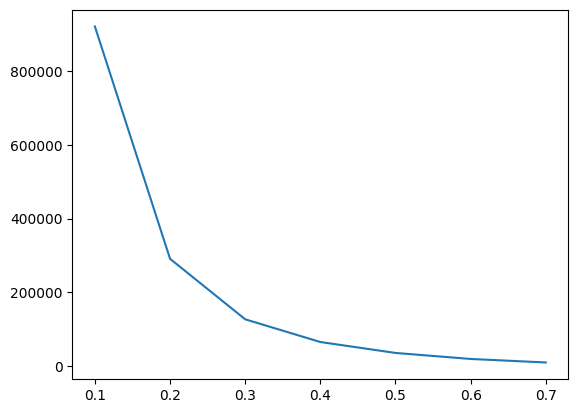

In [11]:
tfidf_cnt = []
tfidf_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

for i in tfidf_range :
    df_bool = (df> i )
    tmp = df_bool.sum().sum()
    print(f'> {i}', tmp)
    tfidf_cnt.append(tmp)
    del df_bool

plt.plot(tfidf_range, tfidf_cnt)
plt.show()

Eventually, following is the new features to be added to the above Baseline.  
When you execute this, Public score will show **1.063**, which is slightly improved (less than expectation, though...).  

ということで、以下がBaselineに追加する特徴量です。  
これを実行すると、Public　scoreは**1.063**と若干良くなります（期待したほどではないですが）。

# 4. Optimize hyper-parameter

After the above attempts, I tried to increase/decrease the learning counts, and found the increasing makes Public score worse while the decreasing improves it. This is why I'd like to optimize Hyper parameter usign Optuna.  

After optimising as below comment-out codes, Public score shows from previous 1.063 to **1.038**, which is the biggest improvement so far.  
Also, it was a bit unexpected for me that the best n_estimators is only 120.  

As the last section of this notebook shows Top20 column ranking which contributed to Light-GBM learning, newly-added 15 features dominates the highest ranking. I guess Light-GBM could efficiently learn using these 15 new features and hence not so many leaning counts would not be required.  

ここまで来たところで、学習回数を少し上下させてみたところ、学習回数を増やすとスコアが悪化、減らすと良化しましたので、Optunaを使ってパラメーターの最適化をしたいと思います。  
以下のコードで調整をしたところ、スコアは1.063から**1.038**へとこれまでで一番大きな改善が見られました。  
最適なn_estimatorsが120回とかなり少ない回数が示されているのもやや意外です。  

Notebook最後にLight-GBMが学習するのに最も貢献したカラムのトップ20を出していますが、それを見ると新たに追加した15の特徴量が上位を独占しています。これらの15のカラムを中心に効率的に学習すれば良いので学習回数は少なくて良いということなのかも知れません。

In [12]:
"""
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'random_seed':42,
        'n_estimators'    :trial.suggest_int('n_estimators', 100, 700),
        'num_leaves'      :trial.suggest_int('num_leaves', 4, 50),
        'max_depth'       :trial.suggest_int("max_depth",1,20),
        'verbose'         :-1
    }
            
    model = lgbm.LGBMClassifier(**params)    
    score_acc = cross_val_score(model, X, y, cv=3, scoring = 'accuracy')
    score = score_acc.mean()    
    
    return score

study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.RandomSampler(seed=42))
study.optimize(objective, n_trials=30) 
study.best_params
"""

'\nimport optuna\noptuna.logging.set_verbosity(optuna.logging.WARNING)\nimport warnings\nwarnings.filterwarnings(\'ignore\')\nfrom sklearn.metrics import mean_absolute_error\nfrom sklearn.model_selection import cross_val_score\n\ndef objective(trial):\n    params = {\n        \'random_seed\':42,\n        \'n_estimators\'    :trial.suggest_int(\'n_estimators\', 100, 700),\n        \'num_leaves\'      :trial.suggest_int(\'num_leaves\', 4, 50),\n        \'max_depth\'       :trial.suggest_int("max_depth",1,20),\n        \'verbose\'         :-1\n    }\n            \n    model = lgbm.LGBMClassifier(**params)    \n    score_acc = cross_val_score(model, X, y, cv=3, scoring = \'accuracy\')\n    score = score_acc.mean()    \n    \n    return score\n\nstudy = optuna.create_study(direction=\'maximize\',\n                            sampler=optuna.samplers.RandomSampler(seed=42))\nstudy.optimize(objective, n_trials=30) \nstudy.best_params\n'

If you run the avobe Optuna, the below will be output, though it takes quite long time.  

かなり時間がかかるのでここではコメントアウトしていますが上記のOptunaを実行すると以下の結果が出力されます。  

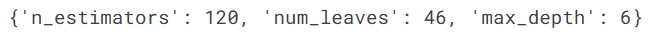

In [13]:
def feat_eng(df, df2, text_columns = text_columns) : 
    for col in text_columns :
        df[f'{col}_len'] = df2[col].apply(lambda x : len(x))
        df[f'{col}_cnt'] = df2[col].apply(lambda x : len(x.split(' ')))
    
        tfv = tfvec.transform(df2[col])
        df.insert(loc=len(df.columns), column=f'{col}_tf_sum', value=np.sum(tfv,axis=1))
        df_bool = (tfv> 0.3 )
        df.insert(loc=len(df.columns), column=f'{col}_tf_cnt', value=df_bool.sum(axis=1))
        df[f"{col}_av_tf"] = df[f"{col}_tf_sum"] / df[f'{col}_cnt']
        
    return df

In [14]:
feat_df = pd.DataFrame()
feat_df = feat_eng(feat_df, train_df) 
feat_df

,prompt_len,prompt_cnt,prompt_tf_sum,prompt_tf_cnt,prompt_av_tf,response_a_len,response_a_cnt,response_a_tf_sum,response_a_tf_cnt,response_a_av_tf,response_b_len,response_b_cnt,response_b_tf_sum,response_b_tf_cnt,response_b_av_tf
0,165,28,2.432517,6,0.086876,4538,656,10.047491,0,0.015316,1206,204,5.849592,1,0.028674
1,200,35,2.545325,5,0.072724,3114,537,6.052538,1,0.011271,3649,591,7.949685,2,0.013451
2,60,9,1.866307,3,0.207367,921,141,3.349863,1,0.023758,1835,282,3.621769,2,0.012843
3,87,18,2.206195,5,0.122566,3182,536,5.557965,3,0.010369,1562,265,4.815292,2,0.018171
4,79,14,1.412451,2,0.100889,1300,236,5.515707,3,0.023372,772,122,4.809422,2,0.039421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57472,157,26,2.593873,5,0.099764,396,60,4.333933,2,0.072232,557,97,2.991255,6,0.030838
57473,257,40,3.104757,6,0.077619,1707,412,3.050078,2,0.007403,1713,381,2.514169,1,0.006599
57474,273,43,2.810795,2,0.065367,8683,1228,9.769684,2,0.007956,1558,254,5.370444,3,0.021143
57475,110,20,2.217656,5,0.110883,435,75,3.261895,4,0.043492,969,159,6.358265,1,0.039989


In [15]:
feat = feat_df.to_numpy()
X = hstack([tfidf_train,feat]) 

In [16]:
y_column = train_df[target_columns].idxmax(axis=1) 
y_column

0        winner_model_a
1        winner_model_b
2            winner_tie
3        winner_model_a
4        winner_model_b
              ...      
57472    winner_model_a
57473    winner_model_a
57474    winner_model_a
57475    winner_model_b
57476    winner_model_a
Length: 57477, dtype: object

In [17]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_column)
y

array([0, 1, 2, ..., 0, 1, 0])

In [18]:
lgb_params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric'   : 'multi_logloss',
    "n_estimators" : 120,
    "num_leaves"   : 46,
    "max_depth"    : 6,
    "verbose"      :-1,
    "random_seed" : 42}

model = lgbm.LGBMClassifier(**lgb_params)

In [19]:
model.fit(X, y)

LGBMClassifier(max_depth=6, metric='multi_logloss', n_estimators=120,
               num_class=3, num_leaves=46, objective='multiclass',
               random_seed=42, verbose=-1)

In [20]:
tfv = []
for col in text_columns :    
    tfv.append(tfvec.transform(test_df[col]))

Test_text = hstack(tfv)

In [21]:
feat_test_df = pd.DataFrame()
feat_test_df = feat_eng(feat_test_df, test_df) 
feat_test_df

,prompt_len,prompt_cnt,prompt_tf_sum,prompt_tf_cnt,prompt_av_tf,response_a_len,response_a_cnt,response_a_tf_sum,response_a_tf_cnt,response_a_av_tf,response_b_len,response_b_cnt,response_b_tf_sum,response_b_tf_cnt,response_b_av_tf
0,86,16,1.709154,3,0.106822,31,5,1.399012,2,0.279802,114,19,2.213014,5,0.116474
1,488,84,2.958104,6,0.035216,1457,217,6.667771,1,0.030727,460,75,3.390263,1,0.045204
2,217,35,2.165237,4,0.061864,3984,634,4.888102,2,0.007710,3716,442,4.053247,1,0.009170


In [22]:
feat_test = feat_test_df.to_numpy()
X_test = hstack([Test_text,feat_test]) 

In [23]:
y_pred = model.predict_proba(X_test)

In [24]:
submission = pd.DataFrame({
    'id': test_df["id"],
    'winner_model_a': y_pred[:, 0],
    'winner_model_b': y_pred[:, 1], 
    'winner_tie'    : y_pred[:, 2]
})

display(submission)
submission.to_csv('submission.csv', index=False)

,id,winner_model_a,winner_model_b,winner_tie
0,136060,0.196567,0.324868,0.478566
1,211333,0.421249,0.307011,0.271739
2,1233961,0.431237,0.302503,0.266260


At last, let's take a quick look which feture is impacting the prediction.  
Column2682 and after is newly added features. Length(2692, 2687) has the biggest impact and, next is the average of Tf-Idf.  

最後に、どの特徴量が予測に貢献しているか見てみましょう。  
2682列以降が追加特徴量なのですが、文章の長さ(2692, 2687)がもっとも影響が大きく、次にTf-Idf(2696, 26891)の平均、となっています。

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

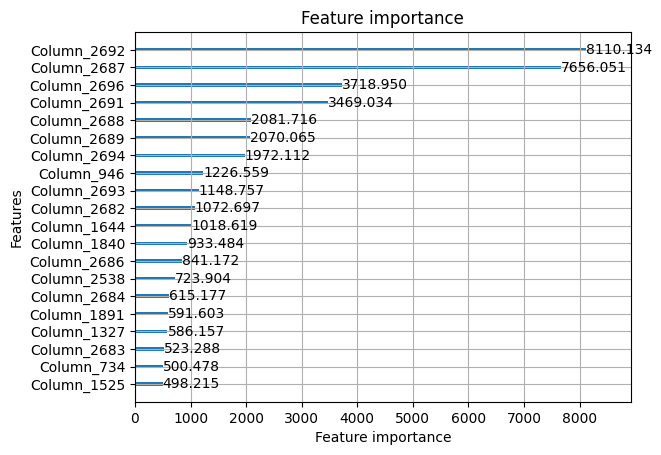

In [25]:
lgbm.plot_importance(model, importance_type="gain",max_num_features=20)

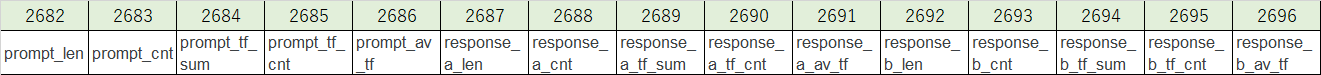